#Imports

The following commands are used to set up and install the Hugging Face Transformers library along with essential dependencies for working with deep learning models. Here's what each command does:

1. !pip install transformers datasets --q
This installs the Transformers library, which provides pre-trained models for NLP tasks, and the Datasets library, which allows easy access to a wide range of datasets. The --q flag suppresses the output to keep the installation process clean.


2. !git clone https://github.com/huggingface/transformers
This command clones the official Transformers repository from GitHub, allowing access to the latest source code. This is useful for those who want to modify the library or work with unreleased features.


3. !pip install /content/transformers
After cloning the repository, this command installs the Transformers library directly from the cloned folder. This is helpful when working with custom modifications or testing the latest code that hasn’t been released on PyPI.


4. !pip install accelerate -U
This installs or updates the Accelerate library, which optimizes model training and inference across different hardware configurations like CPUs, GPUs, and TPUs.


In [ ]:
# Transformers installation
! pip install transformers datasets --q

In [ ]:
!git clone https://github.com/huggingface/transformers
!pip install /content/transformers

fatal: destination path 'transformers' already exists and is not an empty directory.
Processing ./transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.49.0.dev0-py3-none-any.whl size=10742473 sha256=dea073ae687eabc20145c9b4634da639f3e1bb7e51c02176c418e99861d381bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-5yvaiq3q/wheels/7c/35/80/e946b22a081210c6642e607ed65b2a5b9a4d9259695ee2caf5
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.49.0.dev0
    Uninstalling transformers-4.49.0.dev0:
      Successfully uninstalled transformers-4.49.0.dev0


In [ ]:
!pip install accelerate -U

# Prepare the dataset

We decide to use the Tripadvisor reviews dataset (https://huggingface.co/datasets/nhull/tripadvisor-split-dataset-v2)

The first step is to examine the dataset, which consists of star ratings ranging from 0.0 to 4.0, along with corresponding written reviews.
To ensure that the dataset is balanced, we take a closer look at the distribution of ratings to determine whether scaling is necessary. However, in this case, we find that the dataset is already well-balanced.
Before proceeding, we generalize the analysis by renaming "review" to "text" for consistency. Additionally, to avoid complications with data types, we convert the existing float-based star ratings into integers.
We were unable to efficiently convert the float values directly within the same label. Instead, we created a new label and copied the existing values, ensuring that they were converted to integers during the transfer. Once the new label was in place, we deleted the original label along with its data to maintain a clean and consistent dataset.

The last step in our preprocessing is to create smaller subsets of the training and test datasets. We achieve this by shuffling the data with a fixed seed (42) to ensure reproducibility and then selecting the first 400 samples from each. This allows us to work with a more manageable dataset for quick experimentation while maintaining randomness in the selection process.

In [ ]:
#Here we struggled quite a bit with making the features be how we wanted to continue our model creation pipeline. Especially the conversion of floats and integers was difficult
#so we ended up simply creating a copy of "label" in the integer range we wanted and needed, hence we create a new row and remove the old. Also we rename "review" to "text" for
#ease of generalizability and reuseability in future.
from datasets import load_dataset

dataset = load_dataset("nhull/tripadvisor-split-dataset-v2")

dataset = dataset.map(lambda x: {"label2": int(x["label"]) - 1})
dataset = dataset.remove_columns(["label"])
dataset = dataset.rename_column("label2", "label").rename_column("review", "text")

print(dataset["train"][10])


{'text': 'Rude and unhelpful staff\nI\'ve never stayed in Intercontinental. Was looking forward. We came with large group (20 people) for surprise birthday party. upon check-in we were greeted with rude and unhelpful man. We asked for higher floor and were summarily dismissed. Apparently, if you say "sir" enough - they are allowed to be rude. We were, however, offered an 11th floor room with 100 sq ft more for an extra $300! The room is acceptable at best. The coffee only has mugs so you cant make a coffee and go walk around the City. We asked for paper/plastic cups. That was greeted with eye rolling from staff! We were travelling with 7 week old baby. We called in morn and asked for late check out. Was "transferred" to appropriate person - only to be made to wait for ten minutes on hold listening to music. We knew they werent sold out so an extra hour or two would have been helpful. The attitude was remarkable. Finally - they did us a huge "favour" and allowed us check out until 1 pm 

In [ ]:
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(400))
small_eval_dataset = dataset["test"].shuffle(seed=42).select(range(400))

# Training

This is our training process from all the way from tokenization to fine-tuned transformer-based classification model. See comments along the way for explanation throughout.

In [ ]:
#We use the pretrained tokenizer bert-base-cased to tokenize the raw text data from our sample into a format suited for use of a transformer model.
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_small_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
tokenized_small_eval_dataset = small_eval_dataset.map(tokenize_function, batched=True)

In [ ]:
#We remove the column that is the raw text input leaving only the tokenized input.
tokenized_small_train_dataset = tokenized_small_train_dataset.remove_columns(["text"])
tokenized_small_eval_dataset = tokenized_small_eval_dataset.remove_columns(["text"])

In [ ]:
#Slight rename from label to labels as this is expected by the model.
tokenized_small_train_dataset = tokenized_small_train_dataset.rename_column("label", "labels")
tokenized_small_eval_dataset = tokenized_small_eval_dataset.rename_column("label", "labels")


In [ ]:
#We convert into pytorch tensors instead of lists
tokenized_small_train_dataset.set_format("torch")
tokenized_small_eval_dataset.set_format("torch")

In [ ]:
#Here we structure and prepare the data for efficient training using the concept of batching and shuffling by creating a dataloader. With batch_size of 8 we process 8 samples at a time, which is more efficient,
#and we also shufffle in training to prevent the model from memorizing order.
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(tokenized_small_eval_dataset, batch_size=8)

In [ ]:
#We load a pretrained bert model expecting 5 possible labels, which means that the output is a classification head that outputs 5 probablilites for each of our classes, where the highest prediction score wins the label.
#Also using this we take care of loss function as AutoModelForSequenceClassification applies CrossEntropyLoss to the integer labels we ensured we had earlier. Here we calculate loss by testing the models predicted labels with its correct ones.
#If the model assigns the correct class high the loss is low, and opposite way around.
from transformers import AutoModelForSequenceClassification

# 1. Creating a Neural Network
# 1.1 Structure (Architecture) of NN
# 1.2 Loss Function
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#We import AdamW optimizer, which is an optimization algorithm for computing the gradients in backpropagation to update the weights in our optimization of the model.
from torch.optim import AdamW

# 1.3 Optmization Approach
optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
#We take the imported learning rate from above and implement learning rate scheduler, which is set in place to adjust the learning rate throughout training. It stats at lr=5e-5 and then decreases over time until finally 0 or close to.
#Here we also set out number of epochs, which means that the model will train for 3 epochs over the dataset. We also define how many times the learning rate needs to be updated.
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
#We specify the usage of GPU.
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
#Use tqdm for progress bar, which is the number of training steps.
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

#Training loop
model.train()
#We iterate over epochs where each epoch refines the model's weights
for epoch in range(num_epochs):
  #We load a batch, i.e. the 8 from earlier
    for batch in train_dataloader:
      #Use GPU
        batch = {k: v.to(device) for k, v in batch.items()}

        # 2. Forward Pass
        #Here we input the batch into the model and predict the scores
        outputs = model(**batch)

        # 3. FeedForward Evaluation
        #We compute loss using the CrossEntropyLoss which measures the loss of prediction labels, which we attempt to minimize
        loss = outputs.loss

        # 4. Backward Pass / Gradient Calculation
        #Compute gradients so the model can adjust weights in the next step
        loss.backward()

        # 5. Back Propagation / Update Weights
        #We use the optimizer to gradually update the learning rate through each training step.
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/150 [00:00<?, ?it/s]

#Evaluate

Our fine-tuned BERT model for predicting TripAdvisor review ratings (1-5) achieves an accuracy of 60.25%, indicating that it captures meaningful sentiment patterns but struggles with precise classification. Given that a random classifier would achieve 20% accuracy in a five-class problem, this result suggests that the model significantly improves upon chance but remains limited in distinguishing between closely related ratings. The relative improvement over random guessing, computed as:

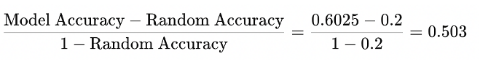

This calculation shows that our model captures 50.3% of the possible improvement space between random and perfect classification. However, the tendency to misclassify ratings that are close in value (e.g., 3-star vs. 4-star) suggests difficulties in capturing subtle sentiment differences, a common challenge in multi-class sentiment classification.
To better understand our model’s performance, we considered alternative approaches. Traditional machine learning models such as Logistic Regression, SVM, and Random Forest provide better interpretability but struggle with contextual understanding. These models rely on hand-crafted features like TF-IDF or word embeddings, which often fail to capture the complexity of natural language sentiment. While they can be useful for simpler classification tasks, they generally underperform compared to transformer-based architectures in nuanced sentiment analysis.
Other deep learning approaches, such as LSTMs and CNNs, offer an alternative to transformers but require significantly more data to achieve similar performance. Recurrent networks like LSTMs are designed to handle sequential text data, yet they struggle with long-range dependencies compared to BERT. Convolutional models, while effective for feature extraction, often fail to grasp the sequential nature of text in the same way transformers do.
Within the transformer family, DistilBERT and RoBERTa present interesting alternatives. DistilBERT, a lighter version of BERT, achieves similar performance with lower computational cost, making it a viable alternative for efficiency-focused applications. RoBERTa, an improved version of BERT trained with optimized pretraining strategies, often outperforms BERT in classification tasks and could potentially yield better results on this dataset.
Overall, our BERT-based model performs moderately well, outperforming traditional ML models and offering better generalization than LSTMs or CNNs given our dataset size. However, its accuracy remains below the ideal threshold for reliable review classification. The primary limitation stems from the small dataset size (400 reviews for training), which restricts the model’s ability to learn nuanced sentiment patterns. To enhance performance, data augmentation, hyperparameter tuning, and alternative transformer architectures could be explored to push accuracy toward the 70-80% range, making the model more robust for real-world rating prediction.

In [ ]:
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.6025}

#Download Model

In order to upload our model to hugging face and make it publicly available to other researcher we have to download our fine tuned model and display it in huggingface.

In [ ]:
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")

torch.save(optimizer.state_dict(), "saved_model/optimizer.pt")
torch.save(lr_scheduler.state_dict(), "saved_model/lr_scheduler.pt")

!zip -r saved_model.zip saved_model


updating: saved_model/ (stored 0%)
updating: saved_model/config.json (deflated 53%)
updating: saved_model/lr_scheduler.pt (deflated 55%)
updating: saved_model/optimizer.pt (deflated 23%)
updating: saved_model/model.safetensors (deflated 7%)
updating: saved_model/vocab.txt (deflated 49%)
updating: saved_model/tokenizer_config.json (deflated 75%)
updating: saved_model/special_tokens_map.json (deflated 42%)
updating: saved_model/tokenizer.json (deflated 70%)


# Model usage example

After posting our model on huggingface we can call on the model through huggingface, which allows us to use the model to evaluate a fabricated review.


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "Esben922/Classification-tripadvisor-review-model"

model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

text = "This was the best hotel experience I have ever had. Thank you very much for this experience."
inputs = tokenizer(text, return_tensors="pt")

outputs = model(**inputs)
predictions = outputs.logits.argmax(dim=-1)

print(predictions.item())


4
